In [1]:
import os
import pickle

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from util.data_loader import (load_dataset, split_train_validation, 
                              custom_random_oversampling, create_csv_submission,
                              change_negative_class)
from util.features_util import keep_features
from util.features_info import FEATURES_DICT, REPLACEMENT_LIST
from util.preprocessing import preprocessing_pipeline, min_max_normalization, z_score_normalization
from util.train import reg_logistic_regression
from util.plotting import loss_visualization
from util.evaluation import evaluation_summary
from util.util import init_random_seeds
from util.predict import predict, predict_no_labels

init_random_seeds()

BASE_PATH = os.path.dirname(os.getcwd()) + "/data"

# Data loading

### ⚠️ Note that the `x_sub` here refers to data for which predictions will be made, but for which we don't have the labels! To refer to the data used for local testing we'll use `x_va` and `y_va` (validation).

In [2]:
# Load data without subsampling
x_train, y_train, x_sub, feature_names = load_dataset(path_x_train=BASE_PATH + "/x_train.csv",
                                                      path_y_train=BASE_PATH + "/y_train.csv",
                                                      path_x_test=BASE_PATH + "/x_test.csv",
                                                      sub_sample=False)
# Create the feature index dictionary
feature_indexes = dict(zip(feature_names, range(len(feature_names))))

# Pre-processing

First we pre-process all the known features, then we preprocess the unkwown ones by simply setting NaNs to -1 and normalising, then merge them

In [3]:
# Keeping only selected features both in train and validation set
x_train_clean, clean_features, clean_feature_index = keep_features(x_train, FEATURES_DICT.keys(), feature_names, feature_indexes, verbose=False)


In [4]:
# Call to the preprocessing pipeline both for train and test set
# NOTE: the preprocessing automatically performs also normalization

x_train_preprocessed = preprocessing_pipeline(x_train_clean, 
                                              where=clean_features,
                                              feature_index=clean_feature_index,
                                              nan_replacement=REPLACEMENT_LIST,
                                              normalize="mixed")

In [19]:
pre_processed_x_raw = x_train.copy()

for feature in [f for f in feature_names if f not in FEATURES_DICT.keys()]:
    # Pre-process features we haven't considered so far
    pre_processed_x_raw[:, feature_indexes[feature]] = np.where(
        np.isnan(pre_processed_x_raw[:, feature_indexes[feature]]),
        -1,
        pre_processed_x_raw[:, feature_indexes[feature]]
    ) 
    
    pre_processed_x_raw[:, feature_indexes[feature]] = min_max_normalization(
        pre_processed_x_raw[:, feature_indexes[feature]]
    )

In [20]:
# Merge the data
x_train_merged = pre_processed_x_raw.copy()

for feature in clean_features:
    x_train_merged[:, feature_indexes[feature]] = x_train_preprocessed[:, clean_feature_index[feature]]

In [21]:
x_train_preprocessed[:5, :]

array([[-5.16368990e-01, -3.64334543e-01,  2.33011611e-01,
        -3.68624462e-01, -5.13990221e-01,  3.29240683e-01,
        -5.13991208e-01,  4.99715772e-01, -4.52766265e-01,
        -9.20883873e-01,  2.07133140e-01,  3.70928714e-01,
         3.23369131e-01,  3.30819055e-01,  2.94488123e-01,
         7.07968388e-01, -2.07101127e+00,  1.90464892e-01,
         4.15382353e-01, -2.81582646e-15,  8.56117131e-01,
         9.72436520e-02, -8.25363654e-01, -5.09393719e-01,
         6.60666303e-02,  9.61193670e-01,  7.45376549e-02,
        -1.77661009e+00,  3.57629002e-01,  3.21952910e-01,
         4.48321174e-01,  2.10082667e-01,  2.85284127e-01,
        -1.39334356e+00, -1.48622146e+00, -1.13523778e+00,
        -2.47261712e+00,  1.69239993e-01,  1.03533052e+00,
        -5.97603414e-01, -3.60344397e-01, -3.39895787e-01,
        -2.29623564e-01, -5.26375541e-01, -2.72053636e-01,
        -3.29446053e-01, -7.19895843e-01, -5.85322165e-02,
        -1.20435394e-01, -4.89462793e-01, -4.90747919e-0

In [22]:
pre_processed_x_raw[:5, :]

array([[-1.73204553,  1.4362964 ,  1.33036073, ...,         nan,
                nan,  0.19931795],
       [-1.73203497,  0.18877218,  1.61711904, ...,         nan,
                nan, -1.64986672],
       [-1.73202442, -0.62211856,  1.04360241, ...,  1.        ,
         2.        ,  0.19931795],
       [-1.73201386,  0.75015808, -0.10343085, ...,  2.        ,
         2.        ,  0.19931795],
       [-1.7320033 , -0.37261372,  1.33036073, ...,  9.        ,
         9.        ,  0.19931795]])

In [23]:
x_train_merged

array([[-1.73204553,  1.4362964 ,  1.33036073, ...,  0.49249331,
         0.53484815,  0.19931795],
       [-1.73203497,  0.18877218,  1.61711904, ...,  0.49249331,
         0.53484815, -1.64986672],
       [-1.73202442, -0.62211856,  1.04360241, ..., -2.03048443,
         0.53484815,  0.19931795],
       ...,
       [ 1.73202442,  0.56302944,  1.04360241, ...,  0.49249331,
         0.53484815,  0.19931795],
       [ 1.73203497,  0.18877218,  1.61711904, ...,  0.49249331,
         0.53484815,  0.19931795],
       [ 1.73204553,  0.12639597,  0.7568441 , ...,  0.49249331,
         0.53484815,  0.19931795]])

## Split local data into train and validation

#### From now on we'll use the local train and validation data: `x_tr` and `y_tr` for training and `x_va` and `y_va` for validation

In [29]:
# Translate labels from -1/1 to 0/1
y_train = change_negative_class(y_train[:, 1], current=-1, new=0)

# Split local data into train and validation
(x_tr, x_va, y_tr, y_va) = split_train_validation(x_train_merged,
                                                  y_train,
                                                  valid_proportion=0.2)

## Data preparation for training

In [30]:
# NO OVERSAMPLING in this version

# Add bias column to the training and validation data
x_tr_bias = np.append(x_tr, np.ones(shape=(x_tr.shape[0], 1)), axis=1)
x_va_bias = np.append(x_va, np.ones(shape=(x_va.shape[0], 1)), axis=1)


# Training

In [31]:
from util.train import reg_logistic_regression_hyperparameters
import pickle

lambdas_ = [0.0001, 0.001, 0.01]
gammas = [0.01, 0.05, 0.1, 0.5]
batch_sizes = [500, 5000, 10000]

hyperparameters = {
    "lambda_": lambdas_,
    "gamma": gammas,
    "batch_size": batch_sizes,
    "optimizer": ["sgd"]
}

In [32]:
x_tr_bias

array([[-1.73204553,  1.4362964 ,  1.33036073, ...,  0.53484815,
         0.19931795,  1.        ],
       [-1.73202442, -0.62211856,  1.04360241, ...,  0.53484815,
         0.19931795,  1.        ],
       [-1.73201386,  0.75015808, -0.10343085, ...,  0.53484815,
         0.19931795,  1.        ],
       ...,
       [ 1.73202442,  0.56302944,  1.04360241, ...,  0.53484815,
         0.19931795,  1.        ],
       [ 1.73203497,  0.18877218,  1.61711904, ...,  0.53484815,
         0.19931795,  1.        ],
       [ 1.73204553,  0.12639597,  0.7568441 , ...,  0.53484815,
         0.19931795,  1.        ]])

In [33]:
res = reg_logistic_regression_hyperparameters(
    x_tr_bias,
    y_tr,
    x_va_bias,
    y_va,
    hyperparameters
)

print(res)

Iteration 0/5000 -> lowest loss inf
Iteration 200/5000 -> lowest loss 3.9374733974334633
Iteration 400/5000 -> lowest loss 2.9818275858219327
Iteration 600/5000 -> lowest loss 2.243405379254657
Iteration 800/5000 -> lowest loss 1.6745085851311505
Iteration 1000/5000 -> lowest loss 1.2734053854602394
Iteration 1200/5000 -> lowest loss 0.9932829932842474
Iteration 1400/5000 -> lowest loss 0.7975039121423684
Iteration 1600/5000 -> lowest loss 0.6575879779903689
Iteration 1800/5000 -> lowest loss 0.5569619820718994
Iteration 2000/5000 -> lowest loss 0.4869106109657166
Iteration 2200/5000 -> lowest loss 0.43511479699438277
Iteration 2400/5000 -> lowest loss 0.39736979427207214
Iteration 2600/5000 -> lowest loss 0.3703113825077351
Iteration 2800/5000 -> lowest loss 0.3492583395052207
Iteration 3000/5000 -> lowest loss 0.33320468832467215
Iteration 3200/5000 -> lowest loss 0.32009705205698014
Iteration 3400/5000 -> lowest loss 0.3093510756438819
Iteration 3600/5000 -> lowest loss 0.3003824219

In [35]:
with open('objs_no_oversampling_mixed.pkl', 'wb') as f:
    pickle.dump(res, f)
    

## Load results

In [37]:
with open('objs_no_oversampling_mixed.pkl', 'rb') as f:
    res = pickle.load(f)

res[0].keys()

dict_keys(['lambda_', 'gamma', 'batch_size', 'optimizer', 'best_weights', 'train_loss', 'valid_loss'])

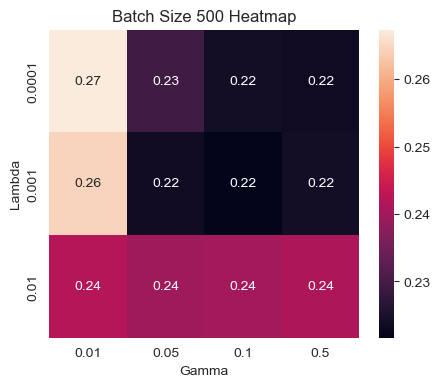

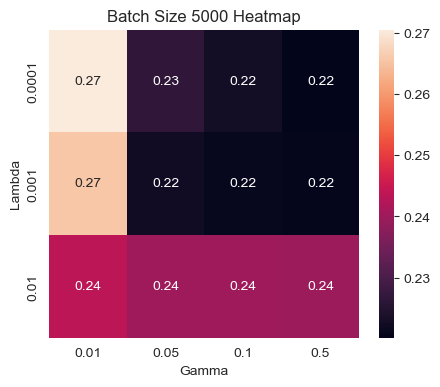

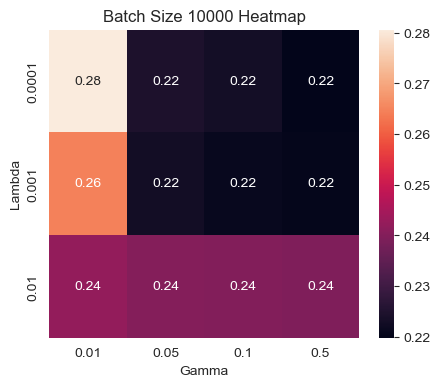

In [38]:
# Plot a heatmap for each batch size
for batch_size in batch_sizes:
    # Filter data for the current batch size
    filtered_res = [d for d in res if d['batch_size'] == batch_size]

    # Create a pivot table for the heatmap
    pivot_res = np.zeros((len(np.unique([d['lambda_'] for d in res])),
                           len(np.unique([d['gamma'] for d in res]))))
    for item in filtered_res:
        lambda_idx = np.where(np.unique([d['lambda_'] for d in res]) == item['lambda_'])[0][0]
        gamma_idx = np.where(np.unique([d['gamma'] for d in res]) == item['gamma'])[0][0]
        pivot_res[lambda_idx, gamma_idx] = item['valid_loss']

    # Create a heatmap
    plt.figure(figsize=(5, 4))
    sns.heatmap(pivot_res, annot=True, xticklabels=np.unique([d['gamma'] for d in res]),
                yticklabels=np.unique([d['lambda_'] for d in res]))
    plt.xlabel('Gamma')
    plt.ylabel('Lambda')
    plt.title(f'Batch Size {batch_size} Heatmap')
    plt.savefig(os.path.dirname(os.getcwd()) + '/plots/' + f'heatmap_batch_size_{batch_size}_new.png')




# Evaluation
### Optimal parameters

In [39]:
res.sort(key=lambda x: x["valid_loss"], reverse=False)
res_opt = res[0]
print("Optimal hyperparameters: gamma {}, lambda {}, batch size {}".format(res_opt["gamma"],
                                                                           res_opt["lambda_"],
                                                                           res_opt["batch_size"]))
print("Minimum validation loss: {}".format(res_opt["valid_loss"]))
w_opt = res_opt["best_weights"]

Optimal hyperparameters: gamma 0.5, lambda 0.0001, batch size 10000
Minimum validation loss: 0.21983152317957433


# Evaluation on validation set

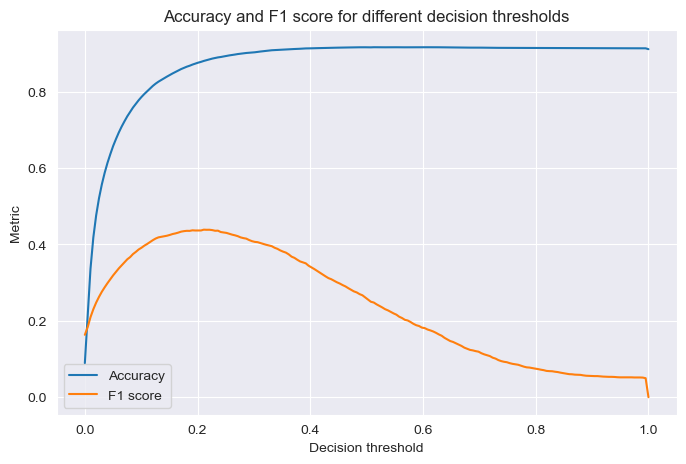

In [42]:
from util.plotting import decision_threshold
opt_threshold = decision_threshold(x_va_bias, w_opt, y_va)

In [43]:
predicted_y_va = predict(x_va_bias,
                         w_opt,
                         threshold=opt_threshold,
                         negative_label=0)
print("EVALUATION SUMMARY ON VALIDATION SET")
evaluation_summary(y_va, predicted_y_va)
print("Optimal threshold -> {:.4f}".format(opt_threshold))

EVALUATION SUMMARY ON VALIDATION SET
Accuracy: 88.03%
Precision: 37.63%
Recall: 52.56%
F1-score: 43.86%
Optimal threshold -> 0.2111


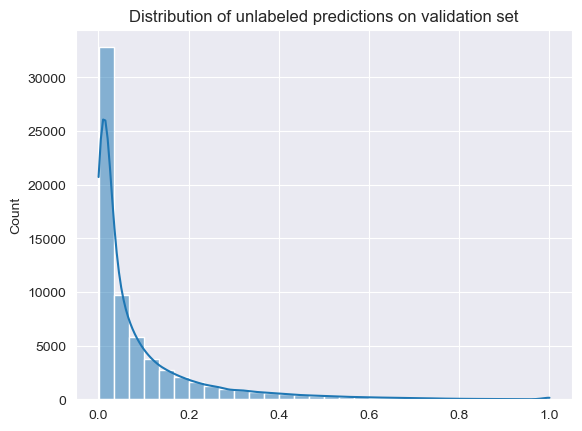

In [44]:
sns.histplot(predict_no_labels(x_va_bias, w_opt), bins=30, kde=True)
plt.title("Distribution of unlabeled predictions on validation set")
plt.show()


---

# COMPUTE RESULT FOR SUBMISSION

In [48]:
ids = x_sub[:, 0]
# Keep only selected features in submission
x_sub_clean, clean_features, clean_feature_index = keep_features(x_sub, FEATURES_DICT.keys(), feature_names, feature_indexes, verbose=False)

x_sub_preprocessed = preprocessing_pipeline(x_sub_clean,
                                            where=clean_features,
                                            feature_index=clean_feature_index,
                                            nan_replacement=REPLACEMENT_LIST,
                                            normalize="mixed")

# Create a copy of the original data for submission
# and preprocess only the "unknown" features
pre_processed_x_raw_sub = x_sub.copy()

for feature in [f for f in feature_names if f not in FEATURES_DICT.keys()]:
    # Pre-process features we haven't considered so far
    pre_processed_x_raw_sub[:, feature_indexes[feature]] = np.where(
        np.isnan(pre_processed_x_raw_sub[:, feature_indexes[feature]]),
        -1,
        pre_processed_x_raw_sub[:, feature_indexes[feature]]
    )

    pre_processed_x_raw_sub[:, feature_indexes[feature]] = min_max_normalization(
        pre_processed_x_raw_sub[:, feature_indexes[feature]]
    )
# Merge the data
x_sub_merged = pre_processed_x_raw_sub.copy()

for feature in clean_features:
    x_sub_merged[:, feature_indexes[feature]] = x_sub_preprocessed[:, clean_feature_index[feature]]

# Add bias column to the submission data
x_sub_bias = np.append(x_sub_merged, np.ones(shape=(x_sub_merged.shape[0], 1)), axis=1)

<Axes: ylabel='Count'>

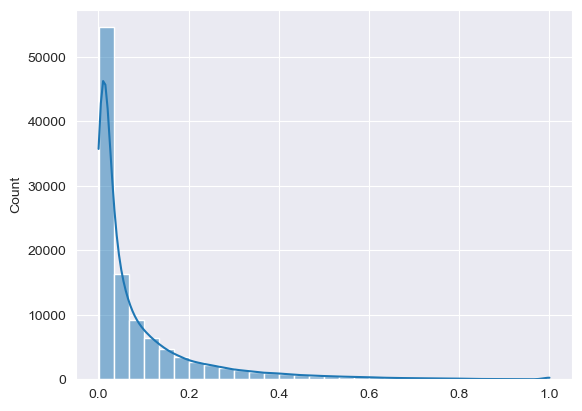

In [49]:
predicted_y_sub = predict(x_sub_bias,
                          w_opt,
                          threshold=opt_threshold,
                          negative_label=-1)

sns.histplot(predict_no_labels(x_sub_bias, w_opt), bins=30, kde=True)

Text(0.5, 1.0, 'Distribution of predictions in submission set')

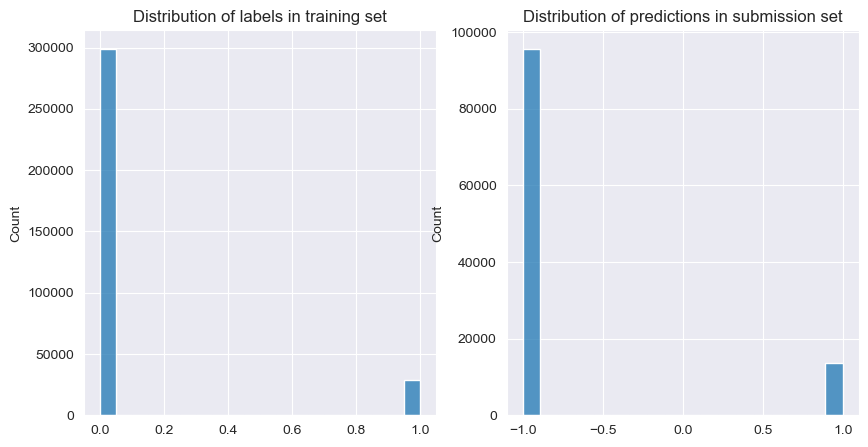

In [50]:
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(10, 5))

sns.histplot(y_train, ax=axs[0])
axs[0].set_title("Distribution of labels in training set")
sns.histplot(predicted_y_sub, ax=axs[1])
axs[1].set_title("Distribution of predictions in submission set")

In [51]:
# Save predictions to csv file

create_csv_submission(ids=ids,
                      y_pred=predicted_y_sub,
                      path=BASE_PATH + "/submission.csv")